# FOOOFGroup

<div class="alert alert-success">
This tutorial covers running FOOOF across multiple power spectra, using FOOOFGroup, an object derived from the base FOOOF object.
</div>

<div class="alert alert-info">
For a more specific exploration of the base FOOOF object, and the underlying algorithm, go [here](02-FOOOF.ipynb).
</div>

In [1]:
# Set matplotlib for plotting in the notebook
%matplotlib inline

# FOOOF imports: get FOOOF & FOOOFGroup objects
from fooof import FOOOFGroup

# Import some utilities for synthesizing some test data
from fooof.synth import gen_group_power_spectra

### Synthesizing Power Spectra

FOOOF includes some basic support for creating synthetic power-spectra, that mimic real data. 

Here we will use that functionality to create a matrix of power spectra to test with. By default, the 'gen_group_power_spectra' takes lists of options for background and gaussian peak parameters, and generates a specified number of power spectra, each one choosing a random combination of parameters.

If you would like to generate single power spectra, you can use 'gen_power_spectrum', also in fooof.synth.

In [2]:
# Set some options for background parameters
#  Generated spectra will have an offset of either [20, 50, 35], and corresponding slope of [2., 2.5, 1.5]
bgp_opts = [[20, 2], [50, 2.5], [35, 1.5]]

# Set some options for peak parameters
#  Generate power spectra will have either no peaks, a 10 Hz peak, or a 10 Hz & 20 Hz peak
gauss_opts = [[], [10, 0.5, 2], [10, 0.5, 2, 20, 0.3, 4]]

In [3]:
# Generate the group of synthetic spectra
freqs, spectra = gen_group_power_spectra(10, [3, 40], bgp_opts, gauss_opts)

### FOOOFGroup

The FOOOFGroup object is very similar to the FOOOF object (programmatically, it inherits from the FOOOF object), and can be used in the same way. The main difference is that instead of running across a single power spectrum, it operates across matrices of multiple power spectra. 

Note that by 'group' we mean merely to refer to a group of power-spectra, not necessarily to a group in terms of multiple subjects or similar. Most likely, a FOOOFGroup will be run across a collection of spectra from across channels, and/or across trials, within or across subjects. 

The main different with the FOOOFGroup object, is that it also contains a 'power_spectra' attribute, which stores the matrix of power-spectra to be fit, and collects fit results into a 'group_results' attribute. Otherwise, FOOOFGroup supports all the same functionality, accessed in the same way as the FOOOF object.

Internally, it runs the exact same fitting procedure, per spectrum, as the FOOOF object.

In [4]:
# Initialize a FOOOFGroup object. It accepts all the same settings as FOOOF()
fg = FOOOFGroup(peak_width_limits=[1, 8], min_peak_amplitude=0.05, max_n_peaks=6)

In [5]:
# Fit a group of power spectra with the .fit() method
#  The key difference (compared to FOOOF) is that it takes a 2D array of spectra
#     This matrix should have the shape of [n_spectra, n_freqs]
fg.fit(freqs, spectra)

In [6]:
# Print out results
fg.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 10                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

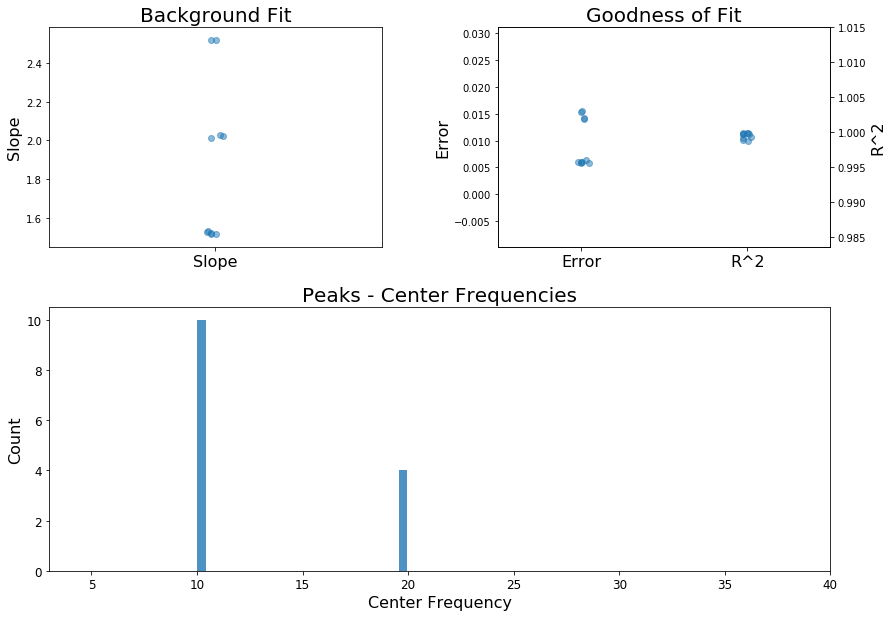

In [7]:
# Plot a summary of the results across the group
#  Note: given the simulations, we expect slopes at {1.5, 2.0. 2.5} and peaks around {10, 20}
fg.plot()

Just as with the FOOOF object, you can call the convenience method 'report' to run the fitting, and print results & plots, printing out the same as above. 

In [8]:
# You can also save out PDFs reports for FOOOFGroup fits, same as with FOOOF
fg.save_report()

In [19]:
# Check what the generated report looks like
from IPython.display import IFrame
IFrame("FOOOFGroup_Report.pdf", width=950, height=1200)

### FOOOFGroup Data

FOOOFGroup collects fits across power spectra into a list of FOOOFResults objects. 

In [10]:
# As it runs, FOOOFGroup collects each fit results in 'group_results'
#  'group_results' is a list of FOOOFResult objects
fg.group_results[0:2]

[FOOOFResult(background_params=array([ 20.06041523,   2.0272546 ]), peak_params=array([[ 10.11207592,   0.46943432,   3.67703901],
       [ 19.96296273,   0.26918462,   7.14332559]]), r_squared=0.99920351696762688, error=0.015305364068303125, gaussian_params=array([[ 10.11207592,   0.46479605,   1.8385195 ],
       [ 19.96296273,   0.26919885,   3.5716628 ]])),
 FOOOFResult(background_params=array([ 20.02418021,   2.01487384]), peak_params=array([[ 10.02933813,   0.48878429,   3.80439785]]), r_squared=0.99985167021968913, error=0.0059582841733569107, gaussian_params=array([[ 10.02933813,   0.48884243,   1.90219892]]))]

In [11]:
# To parse this data, and retrieve specific results, you can use the 'get_all_data' method
#  'get_all_data' lets you extract specific results by specifying a field and (optionally) an index
sls = fg.get_all_data('background_params', 1)
cfs = fg.get_all_data('peak_params', 0)

In [12]:
# Check the fit center-frequencies and slope values
print(cfs)
print(sls)

[ 10.11207592  19.96296273  10.02933813  10.1356732   19.96228252
  10.02766944  10.02342348  10.04067769  10.02249181  10.10250943
  19.96789636  10.05037391  10.09174534  19.91599562]
[ 2.0272546   2.01487384  1.5299757   2.51896949  1.51684502  1.51626491
  2.51575852  1.53167229  1.52191931  2.02445659]


### Saving & Loading with FOOOFGroup

FOOOFGroup also support saving and loading, with same options as saving from FOOOF. 

The only difference in saving FOOOFGroup, is that it saves out a 'jsonlines' file, in which each line is a JSON object, saving the specified data and results for a single power spectrum.

Note that saving settings together with results will save out duplicated settings to each line in the output file, corresponding to each individual spectrum in the group, and so is somewhat inefficient. It is more parsimonious to save out a single settings file, and a separate file that includes the results.

In [13]:
# Save out FOOOFGroup settings & results (separately)
fg.save('FG_settings', save_settings=True)
fg.save('FG_results', save_results=True)

In [14]:
# You can then reload this group data
nfg = FOOOFGroup()
nfg.load()

In [15]:
# Print results to check that the loaded group 
nfg.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 10                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

### Parallel Support

FOOOFGroup also has support for running in parallel.

The fit method includes an optional parameter 'n_jobs', which if set at 1, will run FOOOF linearly, but otherwise will launch n_jobs number of jobs, in parallel. Setting n_jobs to -1 will launch in parallel across all available cores. 

Note, however, that running FOOOF in parallel does not gaurantee a quicker runtime overall. The computation time per FOOOF-fit scales with the frequency range fit over, and the 'complexity' of the power spectra, in terms of number of peaks. For relatively small numbers of power spectra (less than ~100), across relatively small frequency ranges (say ~3-40Hz), running in parallel may offer no appreciable speed up. 

In [16]:
# Run FOOOF fit across a group of power spectra in parallel, using all cores
fg.fit(freqs, spectra, n_jobs=-1)

### Plotting Individual Fits

When running FOOOF across a group of power spectra, results are stored as the FOOOFResults, which store (only) the results of the model fit, not the full model fits themselves. To examine individual model fits, FOOOFGroup can regenerate FOOOF objects for individual power spectra, with the full model available for visualization.

In [17]:
# Extract a particular spectrum, specified by index to a FOOOF object
#  Here we also specify to regenerate the the full model fit, from the results
fm = fg.get_fooof(ind=2, regenerate=True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         35.0617, 1.5300                                          
                                                                                                  
                                       2 peaks were found:                                        
          

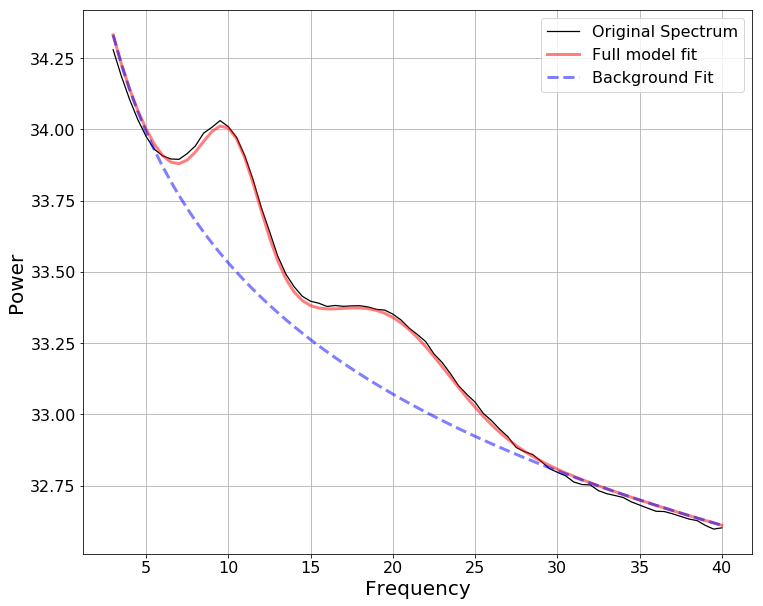

In [18]:
# Print results and plot extracted FOOOF model fit
fm.print_results()
fm.plot()

<hr>
<div class="alert alert-info">
To continue with the tutorial, with more examples of setting parameters, getting good fits, and troubleshooting issues, go [here](05-Tuning&Troubleshooting.ipynb).
</div>